# Importações

In [1]:
import io
import zipfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Consumindo bases

In [2]:
url_sensor = "https://github.com/AILAB-CEFET-RJ/qualiar/raw/main/NEW_TEST/Data/Sensores/sensores.zip"

response = requests.get(url_sensor)
response.raise_for_status()

zip_file = zipfile.ZipFile(io.BytesIO(response.content))

print("Arquivos no ZIP:")
print(zip_file.namelist())

with zip_file.open(zip_file.namelist()[0]) as file:
    df_sensor = pd.read_csv(file)  

df_sensor.head()

Arquivos no ZIP:
['sensores.csv']


,objectid,data,codnum,estação,chuva,pres,rs,temp,ur,dir_vento,...,co,no,nox,o3,pm10,pm2_5,lat,lon,x_utm_sirgas2000,y_utm_sirgas2000
0,2372436,1/1/2011 6:30:00 AM,3,CA,0.2,1009.33,1.57,21.81,84.50,250.67,...,0.17,NaN,NaN,17.89,10.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06
1,2372437,1/1/2011 7:30:00 AM,3,CA,0.0,1009.00,1.40,21.79,84.73,121.17,...,0.21,NaN,NaN,12.44,11.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06
2,2372438,1/1/2011 8:30:00 AM,3,CA,0.2,1008.17,1.37,21.44,85.70,85.67,...,0.17,NaN,NaN,18.97,38.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06
3,2372439,1/1/2011 9:30:00 AM,3,CA,0.0,1008.00,1.30,21.17,88.57,85.33,...,0.22,NaN,NaN,11.08,8.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06
4,2372440,1/1/2011 10:30:00 AM,3,CA,0.2,1008.00,1.32,21.25,89.28,73.00,...,0.22,NaN,NaN,11.28,10.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06


In [3]:
url_estacoes = 'https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/NEW_TEST/Data/Sensores/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

url_qualidade_ar = 'https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/NEW_TEST/Data/Sensores/ind_qual_ar_17_24.csv'

df_qualidade_ar = pd.read_csv(url_qualidade_ar, sep=',')

# Pré-processamento

## Selecionando e criando colunas

In [4]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [5]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5', 'lat', 'lon']

df_sensor_interest = df_sensor[interest_columns]

In [6]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%m/%d/%Y %I:%M:%S %p')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

C:\Users\jhter\AppData\Local\Temp\ipykernel_55240\1024544581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%m/%d/%Y %I:%M:%S %p')
C:\Users\jhter\AppData\Local\Temp\ipykernel_55240\1024544581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
C:\Users\jhter\AppData\Local\Temp\ipykernel_55240\1024544581.py:4: SettingWit

In [7]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[df_sensor_interest['ano'] > 2011]

In [8]:
#@title Filtrando por Campo Grande
df_sensor_pedra_guaratiba = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO PEDRA DE GUARATIBA']

In [9]:
df_qualidade_ar['data_formatada'] = pd.to_datetime(df_qualidade_ar['data']).dt.strftime('%Y-%m-%d')
df_qualidade_ar_pedra_guaratiba= df_qualidade_ar[df_qualidade_ar['estacao_nome'] == 'Pedra de Guaratiba']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação Pedra Guaratiba
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10

### Chuva

In [10]:
df_sensor_pedra_guaratiba['chuva'].describe()

,chuva
count,106695.000000
mean,0.117486
std,1.053585
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,67.600000


In [10]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 7197


In [11]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_pedra_guaratiba['chuva_nulos_no_dia'] = (
    df_sensor_pedra_guaratiba['chuva'].isnull()
    .groupby(df_sensor_pedra_guaratiba['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

C:\Users\jhter\AppData\Local\Temp\ipykernel_55240\3822295001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_pedra_guaratiba['chuva_nulos_no_dia'] = (


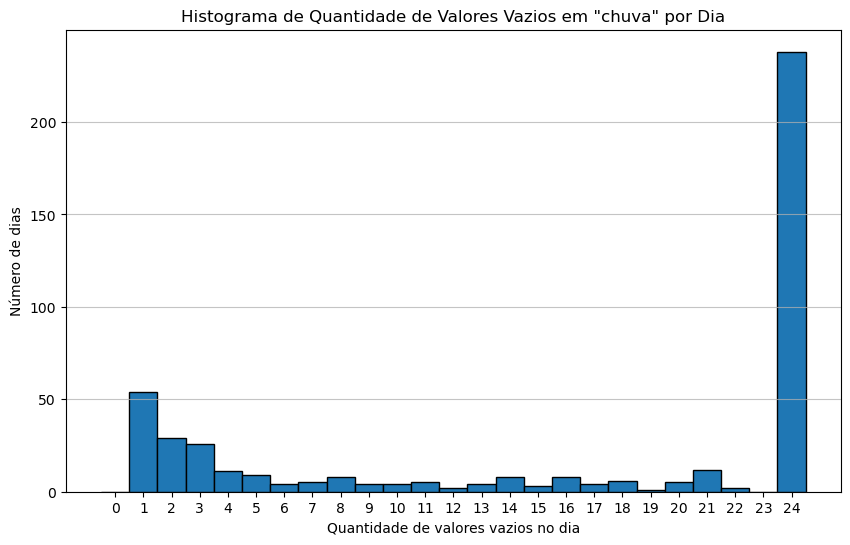

In [12]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [14]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_pedra_guaratiba['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_pedra_guaratiba[mask]['chuva'].isnull().sum()
df_sensor_pedra_guaratiba.loc[mask, 'chuva'] = df_sensor_pedra_guaratiba[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

303 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 4% de dados


In [15]:
df_sensor_pedra_guaratiba['chuva'].describe()

,chuva
count,106998.000000
mean,0.119044
std,1.061717
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,67.600000


### Temperatura

In [16]:
df_sensor_pedra_guaratiba['temp'].describe()

,temp
count,102862.00000
mean,25.61911
std,4.29748
min,0.00000
25%,22.62000
50%,25.18000
75%,28.20000
max,44.73000


In [17]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 11030


In [18]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_pedra_guaratiba['temp_nulos_no_dia'] = (
    df_sensor_pedra_guaratiba['temp'].isnull()
    .groupby(df_sensor_pedra_guaratiba['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-18-1651924770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_pedra_guaratiba['temp_nulos_no_dia'] = (


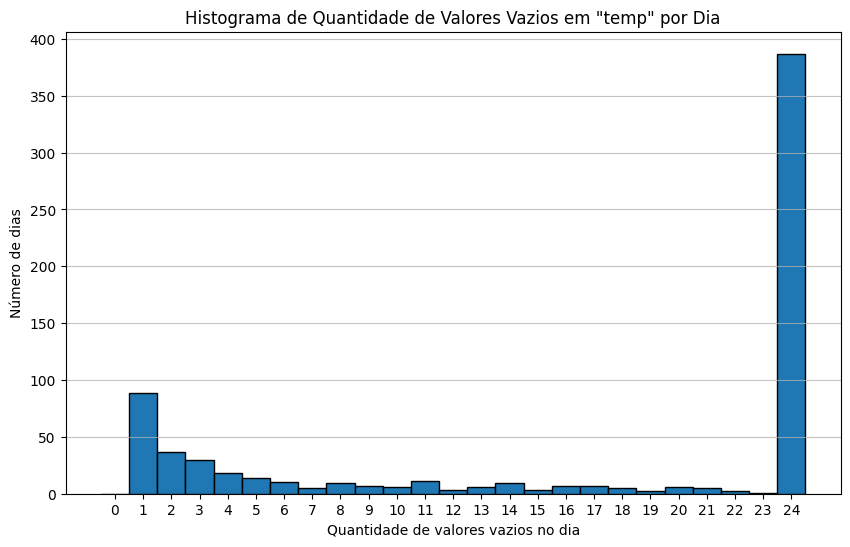

In [19]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [20]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_pedra_guaratiba['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_pedra_guaratiba[mask]['temp'].isnull().sum()
df_sensor_pedra_guaratiba.loc[mask, 'temp'] = df_sensor_pedra_guaratiba[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

455 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 4% de dados


In [21]:
df_sensor_pedra_guaratiba['temp'].describe()

,temp
count,103317.000000
mean,25.625435
std,4.299347
min,0.000000
25%,22.630000
50%,25.200000
75%,28.220000
max,44.730000


### Umidade relativa

In [22]:
df_sensor_pedra_guaratiba['ur'].describe()

,ur
count,74819.000000
mean,77.004265
std,16.945815
min,5.500000
25%,65.430000
50%,79.970000
75%,91.000000
max,100.000000


In [23]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 39073


In [24]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_pedra_guaratiba['ur_nulos_no_dia'] = (
    df_sensor_pedra_guaratiba['ur'].isnull()
    .groupby(df_sensor_pedra_guaratiba['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-24-2920449749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_pedra_guaratiba['ur_nulos_no_dia'] = (


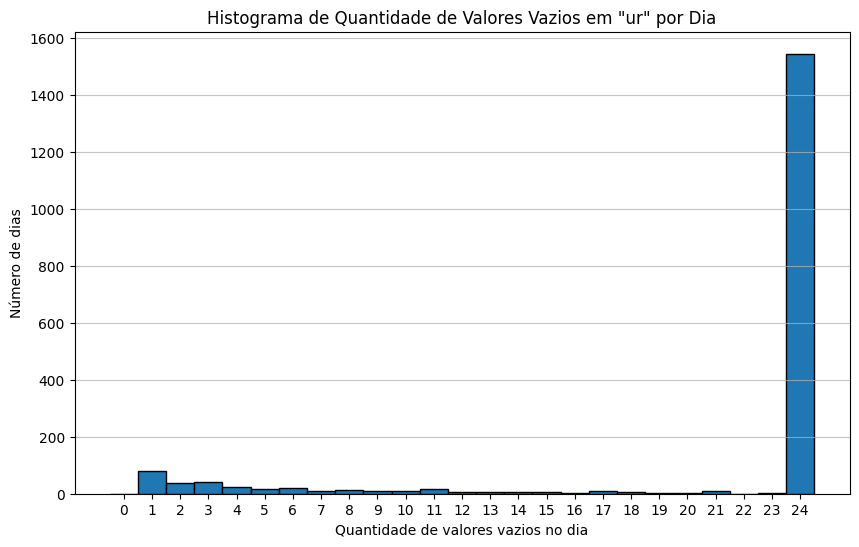

In [25]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [26]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_pedra_guaratiba['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_pedra_guaratiba[mask]['ur'].isnull().sum()
df_sensor_pedra_guaratiba.loc[mask, 'ur'] = df_sensor_pedra_guaratiba[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

566 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 1% de dados


In [27]:
df_sensor_pedra_guaratiba['ur'].describe()

,ur
count,75385.000000
mean,77.060473
std,16.955757
min,5.500000
25%,65.480000
50%,80.070000
75%,91.080000
max,100.000000


### Ozônio

In [28]:
df_sensor_pedra_guaratiba['o3'].describe()

,o3
count,101156.000000
mean,47.525633
std,30.819644
min,0.000000
25%,23.650000
50%,46.085000
75%,66.290000
max,262.650000


In [29]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 12736


In [30]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_pedra_guaratiba['o3_nulos_no_dia'] = (
    df_sensor_pedra_guaratiba['o3'].isnull()
    .groupby(df_sensor_pedra_guaratiba['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-30-2025582274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_pedra_guaratiba['o3_nulos_no_dia'] = (


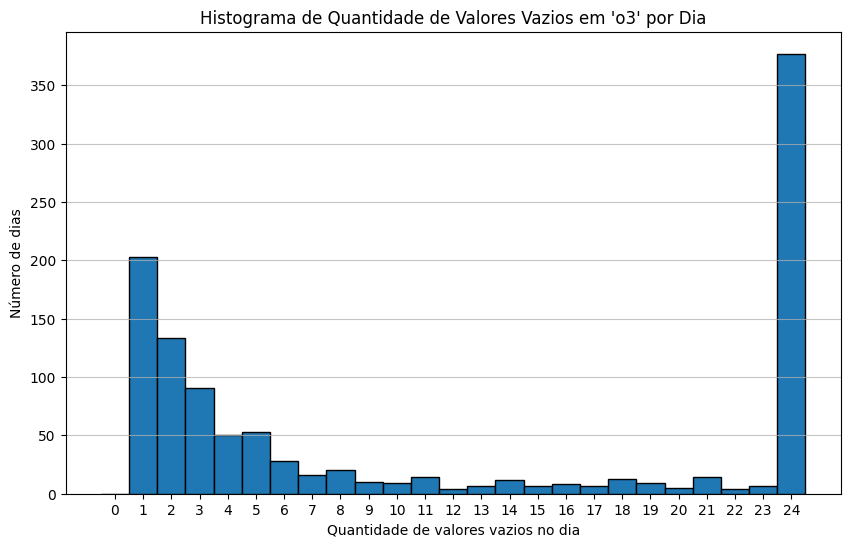

In [31]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [32]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_pedra_guaratiba['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_pedra_guaratiba[mask]['o3'].isnull().sum()
df_sensor_pedra_guaratiba.loc[mask, 'o3'] = df_sensor_pedra_guaratiba[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1375 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 11% de dados


In [33]:
df_sensor_pedra_guaratiba['o3'].describe()

,o3
count,102531.000000
mean,47.530154
std,30.807380
min,0.000000
25%,23.670000
50%,46.110000
75%,66.290000
max,262.650000


### PM10

In [34]:
df_sensor_pedra_guaratiba['pm10'].describe()

,pm10
count,99999.000000
mean,33.685757
std,25.022913
min,0.000000
25%,18.000000
50%,28.000000
75%,42.000000
max,588.000000


In [35]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 13893


In [36]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_pedra_guaratiba['pm10_nulos_no_dia'] = (
    df_sensor_pedra_guaratiba['pm10'].isnull()
    .groupby(df_sensor_pedra_guaratiba['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-36-931347283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_pedra_guaratiba['pm10_nulos_no_dia'] = (


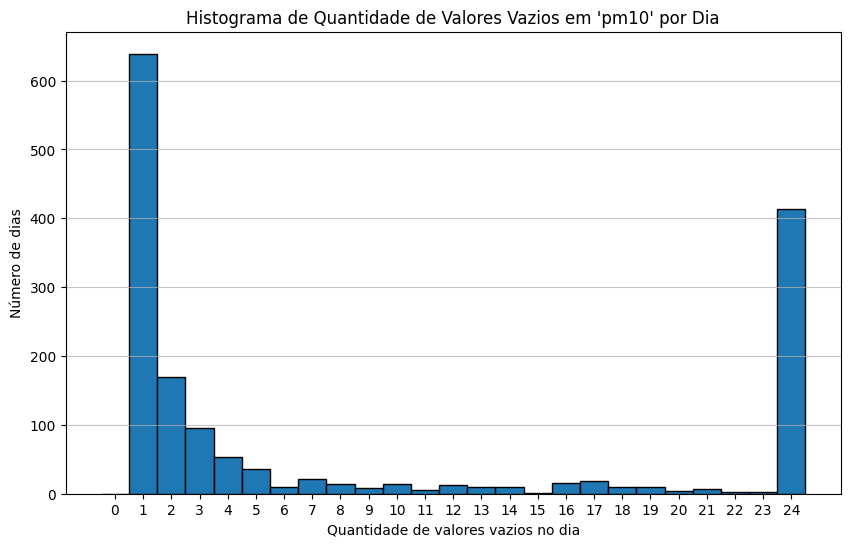

In [37]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_pedra_guaratiba[df_sensor_pedra_guaratiba['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [38]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_pedra_guaratiba['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_pedra_guaratiba[mask]['pm10'].isnull().sum()
df_sensor_pedra_guaratiba.loc[mask, 'pm10'] = df_sensor_pedra_guaratiba[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1720 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 12% de dados


In [39]:
df_sensor_pedra_guaratiba['pm10'].describe()

,pm10
count,101719.000000
mean,33.690687
std,25.013059
min,0.000000
25%,18.000000
50%,28.000000
75%,42.000000
max,588.000000


In [40]:
droping_columns = ['nome_estacao', 'chuva_nulos_no_dia', 'temp_nulos_no_dia', 'ur_nulos_no_dia', 'o3_nulos_no_dia', 'pm10_nulos_no_dia']

df_sensor_pedra_guaratiba.drop(columns=droping_columns, inplace=True)

/tmp/ipython-input-40-1652398241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_pedra_guaratiba.drop(columns=droping_columns, inplace=True)


# Criando nova feature (AQI)

| MP₁₀ (µg/m³) 24h | MP₂.₅ (µg/m³) 24h | O₃ (µg/m³) 8h | CO (ppm) 8h | NO₂ (µg/m³) 1h | SO₂ (µg/m³) 24h | Índice | Qualidade do Ar | Efeitos |
|------------------|------------------|---------------|-------------|----------------|------------------|--------|------------------|---------|
| 0 - 50           | 0 - 25           | 0 - 100       | 0 - 9       | 0 - 200        | 0 - 20           | 0 - 40 | N1 - Boa         | - |
| >50 - 100        | >25 - 50         | >100 - 130    | >9 - 11     | >200 - 240     | >20 - 40         | 41 - 80 | N2 - Moderada     | Pessoas de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas) podem apresentar sintomas como tosse seca e cansaço. A população em geral não é afetada. |
| >100 - 150       | >50 - 75         | >130 - 160    | >11 - 13    | >240 - 320     | >40 - 365        | 81 - 120 | N3 - Ruim         | Toda a população pode apresentar sintomas como tosse seca, cansaço, ardor nos olhos, nariz e garganta. Pessoas de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas) podem apresentar efeitos mais sérios na saúde. |
| >150 - 250       | >75 - 125        | >160 - 200    | >13 - 15    | >320 - 1130    | >365 - 800       | 121 - 200 | N4 - Muito Ruim   | Toda a população pode apresentar agravamento dos sintomas como tosse seca, cansaço, ardor nos olhos, nariz e garganta e ainda falta de ar e respiração ofegante. Efeitos ainda mais graves à saúde de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas). |
| >250 - 600       | >125 - 300       | >200 - 800    | >15 - 50    | >1130 - 3750   | >800 - 2620      | 201 - 400 | N5 - Péssima      | Toda a população pode apresentar sérios riscos de manifestações de doenças respiratórias e cardiovasculares. Aumento de mortes prematuras em pessoas de grupos sensíveis. |


In [41]:
# Carrega o DataFrame
df = df_sensor_pedra_guaratiba.copy()

# Converte e ordena
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values(by='data')

In [42]:
# Define faixas com interpolação linear (c_low, c_high, i_low, i_high)
faixas_aqi = {
    'pm10':   [(0, 50, 0, 40), (50, 100, 41, 80), (100, 150, 81, 120), (150, 250, 121, 200), (250, 600, 201, 400)],
    'pm2_5':  [(0, 25, 0, 40), (25, 50, 41, 80), (50, 75, 81, 120), (75, 125, 121, 200), (125, 300, 201, 400)],
    'o3':     [(0, 100, 0, 40), (100, 130, 41, 80), (130, 160, 81, 120), (160, 200, 121, 200), (200, 800, 201, 400)],
    'co':     [(0, 9, 0, 40), (9, 11, 41, 80), (11, 13, 81, 120), (13, 15, 121, 200), (15, 50, 201, 400)],
    'no2':    [(0, 200, 0, 40), (200, 240, 41, 80), (240, 320, 81, 120), (320, 1130, 121, 200), (1130, 3750, 201, 400)],
    'so2':    [(0, 20, 0, 40), (20, 40, 41, 80), (40, 365, 81, 120), (365, 800, 121, 200), (800, 2620, 201, 400)],
}

In [43]:
# Função de interpolação para cálculo contínuo do AQI
def calcular_aqi(valor, faixas):
    for c_low, c_high, i_low, i_high in faixas:
        if c_low <= valor <= c_high:
            return ((i_high - i_low) / (c_high - c_low)) * (valor - c_low) + i_low
    return np.nan  # Fora das faixas

In [44]:
# Função para média 8h móvel diária (máxima por dia)
def media_8h_movel(df, col):
    resultados = []
    for dia, grupo in df.groupby('data_formatada'):
        grupo = grupo.sort_values('data')
        grupo = grupo.set_index('data')
        rol = grupo[col].rolling('8h', min_periods=6).mean()
        max_rol = rol.max()
        resultados.append((dia, max_rol))
    return pd.Series(dict(resultados))

In [45]:
# Médias 24h dos poluentes diários
df_diario = df.groupby('data_formatada')[['pm10', 'pm2_5', 'so2']].mean()

# Médias móveis 8h para O3 e CO
o3_8h_max = media_8h_movel(df, 'o3')
co_8h_max = media_8h_movel(df, 'co')

# NO2: pega maior valor por dia
no2_1h_max = df.groupby('data_formatada')['no2'].max()

# Monta df_aqi
df_aqi = df_diario.copy()
df_aqi['o3_8h_max'] = o3_8h_max
df_aqi['co_8h_max'] = co_8h_max
df_aqi['no2_1h_max'] = no2_1h_max

In [46]:
# Aplica cálculo de AQI contínuo por poluente
for poluente, faixas in faixas_aqi.items():
    col_ref = {
        'o3': 'o3_8h_max',
        'co': 'co_8h_max',
        'no2': 'no2_1h_max'
    }.get(poluente, poluente)

    df_aqi[f'{poluente}_aqi'] = df_aqi[col_ref].apply(
        lambda x: calcular_aqi(x, faixas) if pd.notnull(x) else np.nan
    )

# AQI final do dia: maior valor entre os poluentes
col_aqis = [f'{p}_aqi' for p in ['pm10', 'pm2_5', 'so2', 'o3', 'co', 'no2']]
df_aqi['aqi'] = df_aqi[col_aqis].max(axis=1)

In [47]:
# Classificação da qualidade do ar com base no AQI real
def classifica_qualidade(aqi):
    if aqi <= 40:
        return 'N1 - Boa'
    elif aqi <= 80:
        return 'N2 - Moderada'
    elif aqi <= 120:
        return 'N3 - Ruim'
    elif aqi <= 200:
        return 'N4 - Muito Ruim'
    else:
        return 'N5 - Péssima'

df_aqi['classificacao'] = df_aqi['aqi'].apply(classifica_qualidade)
df_aqi.reset_index(inplace=True)

In [48]:
# Arredonda o AQI final para inteiro
df_aqi['aqi'] = df_aqi['aqi'].round().astype('Int64')

# Mantém apenas as colunas desejadas
df_aqi = df_aqi[['data_formatada', 'aqi', 'classificacao']]

In [49]:
# Agrupamento por data_formatada
df_gruped = df_sensor_pedra_guaratiba.groupby('data_formatada', as_index=False).mean()

# Merge com a tabela de qualidade do ar
df_merged = df_gruped.merge(
    df_aqi[['classificacao', 'aqi', 'data_formatada']],
    left_on='data_formatada',
    right_on='data_formatada',
    how='left'
)

In [50]:
df_merged.shape

(4750, 19)

In [51]:
df_sensor_pedra_guaratiba.head()

,data,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,lat,lon,data_formatada,ano,mes
490825,2012-01-01 03:30:00,0.8,24.07,99.56,NaN,NaN,NaN,NaN,NaN,24.52,74.0,NaN,-23.004379,-43.62901,2012-01-01,2012,1
490826,2012-01-01 04:30:00,1.2,24.07,99.40,NaN,NaN,NaN,NaN,NaN,28.16,34.0,NaN,-23.004379,-43.62901,2012-01-01,2012,1
490827,2012-01-01 05:30:00,0.4,24.17,96.38,NaN,NaN,NaN,NaN,NaN,42.38,41.0,NaN,-23.004379,-43.62901,2012-01-01,2012,1
490828,2012-01-01 06:30:00,0.6,24.03,94.49,NaN,NaN,NaN,NaN,NaN,45.37,17.0,NaN,-23.004379,-43.62901,2012-01-01,2012,1
490829,2012-01-01 07:30:00,0.2,23.88,97.84,NaN,NaN,NaN,NaN,NaN,29.45,22.0,NaN,-23.004379,-43.62901,2012-01-01,2012,1


In [52]:
df_sensor_pedra_guaratiba.to_csv('pedra_guaratiba_per_hour.csv', index=False)

# Gerando CSV de saída com a estação de Campo Grande preenchida


In [ ]:
df_merged['lat'] = -23.004379
df_merged['lon'] = -43.62901
df_merged['estacao'] = 'Pedra de Guaratiba'
df_merged['ano'] = pd.to_datetime(df_merged['data_formatada']).dt.year
df_merged['mes'] = pd.to_datetime(df_merged['data_formatada']).dt.month

In [ ]:
df_merged.head()

,data_formatada,data,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,lat,lon,ano,mes,classificacao,aqi,estacao
0,2012-01-01,2012-01-01 13:30:00,1.561905,25.298571,92.982857,NaN,NaN,NaN,NaN,NaN,37.054762,20.142857,NaN,-23.004379,-43.62901,2012,1,N1 - Boa,17,Pedra de Guaratiba
1,2012-01-02,2012-01-02 12:00:00,1.141667,23.154583,93.573333,NaN,NaN,NaN,NaN,NaN,47.928750,8.666667,NaN,-23.004379,-43.62901,2012,1,N1 - Boa,21,Pedra de Guaratiba
2,2012-01-03,2012-01-03 12:00:00,0.000000,24.197083,82.005000,NaN,NaN,NaN,NaN,NaN,16.141250,18.176471,NaN,-23.004379,-43.62901,2012,1,N1 - Boa,15,Pedra de Guaratiba
3,2012-01-04,2012-01-04 12:00:00,0.000000,24.976667,78.547917,NaN,NaN,NaN,NaN,NaN,34.663333,31.333333,NaN,-23.004379,-43.62901,2012,1,N1 - Boa,27,Pedra de Guaratiba
4,2012-01-05,2012-01-05 12:00:00,0.000000,24.998000,80.963333,NaN,NaN,NaN,NaN,NaN,37.833333,27.041667,NaN,-23.004379,-43.62901,2012,1,N1 - Boa,26,Pedra de Guaratiba


In [ ]:
# Reorder columns
new_order = ['data_formatada', 'estacao', 'ano', 'mes', 'lat', 'lon',
             'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5',
             'aqi', 'classificacao']
df_merged = df_merged[new_order]

display(df_merged.head())

,data_formatada,estacao,ano,mes,lat,lon,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,aqi,classificacao
0,2012-01-01,Pedra de Guaratiba,2012,1,-23.004379,-43.62901,1.561905,25.298571,92.982857,NaN,NaN,NaN,NaN,NaN,37.054762,20.142857,NaN,17,N1 - Boa
1,2012-01-02,Pedra de Guaratiba,2012,1,-23.004379,-43.62901,1.141667,23.154583,93.573333,NaN,NaN,NaN,NaN,NaN,47.928750,8.666667,NaN,21,N1 - Boa
2,2012-01-03,Pedra de Guaratiba,2012,1,-23.004379,-43.62901,0.000000,24.197083,82.005000,NaN,NaN,NaN,NaN,NaN,16.141250,18.176471,NaN,15,N1 - Boa
3,2012-01-04,Pedra de Guaratiba,2012,1,-23.004379,-43.62901,0.000000,24.976667,78.547917,NaN,NaN,NaN,NaN,NaN,34.663333,31.333333,NaN,27,N1 - Boa
4,2012-01-05,Pedra de Guaratiba,2012,1,-23.004379,-43.62901,0.000000,24.998000,80.963333,NaN,NaN,NaN,NaN,NaN,37.833333,27.041667,NaN,26,N1 - Boa


In [ ]:
df_merged.to_csv('pedra_guaratiba.csv', index=False)